In [41]:
import scipy.special as sp
import math as ma
import numpy as np
import scipy.stats as st
import numba as nb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Bayesian inference of discontinuous composite model

The model has pdf 

$$
f(x) = \begin{cases}
pf_1(x)/F_1(\gamma)& \text{ if }x\leq \gamma \\
(1-p)f_2(x)/\overline{F}_2(\gamma)&\text{ if }x> \gamma
\end{cases},
$$
where $f_1$ is the gamma pdf with 

$$
f_1(x) = \frac{x^{r-1}e^{-x/m}}{\Gamma(r)m^r},\text{ } x>0
$$

and f_2 is the Pareto type 2 distribution with 

$$
f_2(x) = \frac{\alpha \gamma^\alpha}{x^{\alpha+1}}\text{ } x>\gamma
$$

The following method simulate data from this model

In [4]:
def sim_dis_gam_par(n, r, m, α, γ, p):
    """
    Sample from a discontinuous Gamma-Pareto model.

    Parameters
    ----------
    n : int 
        sample size.
    r : float
        shape parameter of the Gamma distribution.
    m : float
        scale parameter of the Gamma distribution.
    α : float
        Tail index of the Pareto distribution.
    γ : float
        Threshold parameter of the composite model.
    p: float
        mixing parameter of the composite model

    Returns
    -------
    array
    A sample drawn from the dicontinuous gamma-Pareto distribution.
    
    Example
    -------
    n, r, m, α, γ, p = 10, 2, 3, 1/2, 5, 1/3
    X = sim_dis_gam_par(n, r, m, α, γ, p)
    """    
    gamma_rv = st.gamma(r)
    par_rv = st.pareto(α)
    binom_rv =  st.binom(1, p)
    par_rvs = γ * par_rv.rvs(size = n)
    binom_rvs = binom_rv.rvs(size = n)
    gamma_rvs = m * gamma_rv.ppf(sp.gammainc(r, γ / m) *\
                               np.random.uniform(size = n))
    return(binom_rvs * gamma_rvs + (1 - binom_rvs) * par_rvs)

The following method provides the a computational tool for the log likelihood of the model

In [175]:
@nb.jit(nopython = True)
def reg_inc_gamma(a,x):
    """
    Compute the regularized incomplete gamma function.

    Parameters
    ----------
    a : float 
        parameter of the gamma function.
    x : float
        upper bound of the integral.

    Returns
    -------
    float
    Value of the regularized incomplete gamma function
    
    Example
    -------
    a, x = 3, 1 
    sp.gammainc(a, x),  reg_inc_gamma(a,x)
    """
    xam = -x + a * np.log(x)
    if x <= 1 + a:
        s = 1/a
        r = s
        for j in np.arange(1, 61, 1):
            r = r * x / (a + j)
            s = s + r
            if (abs(r /s) < 1e-15):
                break
        gin  = np.exp(xam) * s
        ga = ma.gamma(a)
        gip = gin / ga
        gim = ga - gin
    else:
        t0 = 0
        for j in np.flip(np.arange(1, 61, 1)):
            t0 = (j - a) / (1 + j / (x + t0))
        gim  = np.exp(xam) / (x + t0)
        ga = ma.gamma(a)
        gin = ga - gim
        gip = 1 - gim / ga
    return(gip)

def logp_dis_gam_par(X):
    """
    Likelihood function of the discontinuous Gamma-Pareto model.

    Parameters
    ----------
    X : Array 
        Insurance losses.

    Returns
    -------
    function
    Allows the evaluation of the likelihood in the parameters provided the 
    data.
    
    Example
    -------
    n, r, m, α, γ, p = 10, 2, 3, 1/2, 5, 1/3
    X = sim_dis_gam_par(n, r, m, α, γ, p)
    logp = logp_dis_gam_par(X)
    logp(np.array([2, 3, 1/2, 5, 1/3]))
    costFn = lambda parms: -logp(parms)
    bnds = ((0, None), (0, None), (0, None))
    θ0 = (1, 1, 1)
    minRes = minimize(costFn, θ0,bounds=bnds)
    minRes
    """
    def logp(parms):
        r, m, α, γ, p = parms
        
        if np.all(parms > 0):
            if p > 0 and p < 1:
                X1 = X[X < γ]
                X2 = X[X >= γ]
                F1 = reg_inc_gamma(r, γ / m)
                    
                return(len(X1) * (np.log(p) - np.log(F1) - np.log(ma.gamma(r)) - \
                                  r * np.log(m)) - np.sum(X1) / m +\
                       (r-1) * np.sum(np.log(X1)) + len(X2) *(np.log(1-p) +\
                        np.log(α) + α * np.log(γ)) - (α + 1) * np.sum(np.log(X2))
                       )
            else: 
                return(-np.inf)
            
        else:
            return(-np.inf)
    return nb.jit(nopython = True)(logp)

def logd_gam_par(parms):
    """
    density function of the Gamma-Pareto model.

    Parameters
    ----------
    parms : ndArray 
        particles.

    Returns
    -------
    function
    Allows the evaluation of the density functions for multiple parameter
    values.
    """
    r, m, α, γ, p = parms[:,0], parms[:,1], parms[:,2], parms[:,3], parms[:,4]
#     β = θ / (k + α)
#     r = α*sp.gamma(k)*  sp.gammainc(k,θ / β) * np.exp(k+α)*(k+α)**(-k) / \
#         (1+ α*sp.gamma(k) * sp.gammainc(k, θ / β) * np.exp(k+α)*(k+α)**(-k))
    F1 = sp.gammainc(r, γ / m)
    def logd(x):
        res = np.zeros(len(α))
        s = np.logical_and(m > 0, p > 0, p < 1)
        s1 = np.logical_and(s, x < γ)
        s2 = np.logical_and(s, x >= γ)
        
        res1 = np.log(p[s1]) - np.log(F1[s1]) - np.log(sp.gamma(r[s1])) - \
            r[s1] * np.log(m[s1]) - x / m[s1] + (r[s1]-1) * np.log(x)

        res2 = (np.log(1-p[s2]) + np.log(α[s2]) + α[s2] * \
                np.log(γ[s2])) - (α[s2] + 1) * np.log(x)
        
        res[np.where(s1)] = res1
        res[np.where(s2)] = res2
        res[np.where(np.invert(s))] = -np.inf
        return(res)
    return logd

The model has 5 unknown parameters. The prior distributions setting are independant gamma and beta as follows

$$
p\sim \text{Beta}(a_p, b_p),\text{, }r\sim \text{Gamma}(a_r, b_r)\text{, }m\sim \text{Gamma}(a_m, b_m)\text{, }\alpha\sim \text{Gamma}(a_\alpha, b_\alpha)\text{, and }\gamma\sim \text{Gamma}(a_\gamma, b_\gamma)
$$

The following method samples from such a prior distribution

In [59]:
def sim_gamma_beta_prior(a, b, parms_names, popSize):
    """
    Sample from independent gamma priors and one beta prior.

    Parameters
    ----------
    a : array 
        shape hyperparameters.
    b : array
        scale hyperparameters.
    parms_names: array
        name of the parameters
    popSize: int
        sample size
        
    Returns
    -------
    dataframe
    Initialize parameters value from the independent 
    gamma prior distribution.
    
    Example
    -------
    a, b, parms_name, popSize   = [0.1, 0.1, 0.1], [10, 10, 10],\
        ['k','α', 'θ'], 10
    sim_gamma_prior(a, b, parms_name, popSize)
    """
    mat = [st.gamma(a[j]).rvs(popSize) / b[j] 
               for j in range(len(a)-1)]
    mat.append(st.beta(a[-1], b[-1]).rvs(popSize))
    res = pd.DataFrame(np.matrix(mat).transpose())
    res.columns = parms_names
    return res
 

In [110]:
np.dot((a_gammas - 1), np.log(gammas)), np.sum((a_gammas - 1) * np.log(gammas))

(27.963261207236364, 27.963261207236368)

In [113]:
def logp_gamma_beta_prior(a, b):
    """
    log probabilities of independent gamma priors and one beta prior.

    Parameters
    ----------
    a : array 
        shape hyperparameters.
    b : array
        scale hyperparameters.
    

    Returns
    -------
    function
    Allows to evaluate the log probabilities in the proposed parameters.
    
    Example
    -------
    """
    def logp_prior(parms):
        gammas, beta, a_gammas, a_beta, b_gammas, b_beta = parms[:len(parms)-1], parms[-1], a[:len(parms)-1], a[-1], b[:len(parms)-1], b[-1]
        if np.all(parms)>0 and beta < 1:
            l_gamma =  np.sum((a_gammas - 1) * np.log(gammas)) - np.sum(gammas * b_gammas) + np.sum(a_gammas * np.log(b_gammas)) - np.sum(np.log(np.array([ma.gamma( a_scalar ) for a_scalar in a_gammas])))
            l_beta = (a_beta - 1)*np.log(beta) + (b_beta - 1)*np.log(1 - beta) +  np.log(ma.gamma(a_beta)) + np.log(ma.gamma(b_beta)) - np.log(ma.gamma(a_beta + b_beta))

            return(l_gamma + l_beta)
        else:
            return(-np.inf)
    return nb.jit(nopython=True)(logp_prior)

In [114]:
parms_names = ["r","m", "α", "γ" , "p"]
a, b, popSize = np.append(0.1*np.ones(len(parms_names)-1), 2), np.append(0.1*np.ones(len(parms_names)-1), 2.0), 10
particle_cloud = sim_gamma_beta_prior(a, b, parms_names, popSize)
particles = particle_cloud.values
logp_prior = logp_gamma_beta_prior(a, b)
[logp_prior(parms) for parms in particles]

[13.205566501705341,
 28.26549297350392,
 -3.8847969362037413,
 3.953301411628827,
 42.7686106752453,
 -5.272158561529476,
 -3.1464087675467085,
 26.372636315832985,
 -4.080174959481209,
 -3.529625132051783]

In [117]:
@nb.jit(nopython=True)
def Gibbs_move(n_moves, step_size, log_prob, log_prob_prior, init_parms, γ, d):   
    
    accepted_matrix = [np.repeat(False,d)]
   
    trace = [init_parms]
    

    # epsilon = np.random.multivariate_normal(mean = np.zeros(d), 
    #                                       cov = np.diag(step_size), size = n_moves)
    
    # for noise in np.atleast_2d(epsilon):
    for j in range(n_moves):
        parms_perturbed = trace[-1].copy()
        parms_new = trace[-1].copy()
        accepted = []
        for i in range(d):
            noise = np.random.normal(0, np.sqrt(step_size[i]))
            parms_perturbed[i] = parms_perturbed[i] + noise
            
            parms_new[i] = parms_perturbed[i]
            # acceptance rate
            old_log_p = γ * log_prob(trace[-1]) + log_prob_prior(trace[-1])
            new_log_p = γ * log_prob(parms_new) + log_prob_prior(parms_new)        
            ###
            acc =  new_log_p - old_log_p 
            ###       
            if np.log(np.random.rand()) < acc:
                parms_new[i] = parms_perturbed[i]
                accepted.append(True)
            else:
                parms_new[i] = trace[-1][i]
                # np.put(parms_new, i, trace[-1][i])
                accepted.append(False)
        trace.append(parms_new) 
        accepted_matrix.append(np.array(accepted))
                
     
    return(trace, accepted_matrix)

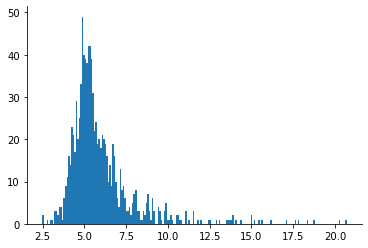

In [141]:
n, r, m, α, γ, p = 1000, 10, 3, 4, 5, 1/3
true_parms = np.array([r, m, α, γ, p])
X = sim_dis_gam_par(n, r, m, α, γ, p)
plt.hist(X,bins=200)
sns.despine()

In [151]:
n_moves, step_size, log_prob, log_prob_prior, init_parms, τ, d = 15000, np.array([2.70530558e+00, 3.63055785e+01, 2.76341899e-02, 9.39764106e-03,
       2.27288158e-03]), logp_dis_gam_par(X), logp_gamma_beta_prior(a, b), particles[0], 1, len(particles[0])
trace, acceptance = Gibbs_move(n_moves, step_size, log_prob, log_prob_prior, init_parms, τ, d)
trace_gibbs = pd.DataFrame(trace).iloc[int(n_moves / 2):]
trace_gibbs.columns = parms_names

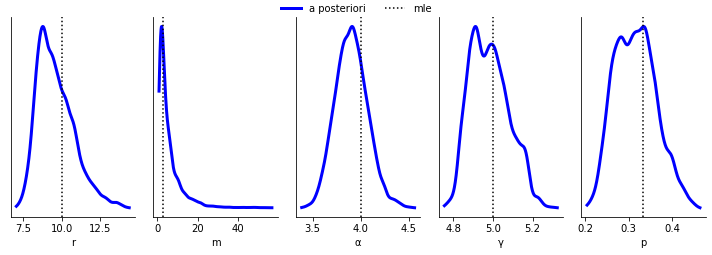

In [152]:
fig, axs = plt.subplots(1, len(parms_names), figsize=(10, 3.5))
x_labs = parms_names
for k in range(len(x_labs)):
    positions = np.linspace(min(trace_gibbs[parms_names[k]]), max(trace_gibbs[parms_names[k]]), 1000)
    kernel = st.gaussian_kde(trace_gibbs[parms_names[k]])
    axs[k].plot(positions, kernel(positions), lw=3, label = "a posteriori", color = "blue")

    axs[k].axvline(true_parms[k], color = "black", linestyle = "dotted", label = "mle")
    axs[k].set_yticks([])
#     axs[k].set_xticks(np.round(
#         trace_gibbs[parms_names[k]].quantile([0.05, 0.95]).values, 2))
    axs[k].set_xlabel(x_labs[k])

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol = 3, borderaxespad=0., loc='upper center', 
           frameon=False)
sns.despine()
fig.tight_layout()

In [165]:
def temperature_search(particles, log_probs, target, γ_prev, err):
    """
    Provides the next temperature given the previous generation of particles.

    Parameters
    ----------
    particles : ndarray 
        cloud of particles.
    target : int
        Effective sample size target, default is popSize / 2.
    γ_prev : float
        Previous temperature.
    err: float
        Temperature threshold
        
    Returns
    -------
    list
    A list that provides the next temperature, the unnormalized weights w, 
    the normalized weights W, and the effective sample size.
    
    Example
    -------
    k, α, θ = 1/2, 1/2, 5 
    X = sim_wei_par(100, k, α, θ)
    popSize, a, b, c, ρ, n_step_max,loss_model, prior, parms_names = 20, [0,0,0], [10,10,10],\
    0.99, 1/2, 25,"wei_par", "uniform", ['k','α', 'θ']
    init_cloud = sim_uniform_prior(a, b, parms_names, popSize)
    init_cloud['w'] = np.ones(popSize)
    init_cloud['W'] = np.ones(popSize) / popSize

    particles, target, γ_prev, model, method = init_cloud[parms_names] ,  
    ρ * popSize, 0, "wei-par", "likelihood annealing"
    temperature_search(X, particles, popSize, target, γ_prev, model, method)
    """
    γ_up, γ_down = 2, γ_prev
    popSize, d = particles.shape
#     log_probs = np.array([log_prob(particle) for particle in particles])
    if np.any(np.isnan(log_probs)):
        log_probs[np.where(np.isnan(log_probs))] = -np.inf
    while γ_up - γ_down > err:
        γ_new = (γ_up + γ_down) / 2
        
        logw =  log_probs*(γ_new - γ_prev)
        if np.all(logw == - np.inf):
            #  This will cancel out this iteration 
            # in the log marginal likelihood computation
            logw = np.log(np.ones(popSize))
            W = 1 / popSize *np.ones(popSize)
            ESS = 0
        else:
            W = np.exp(logw - max(logw)) / np.sum(np.exp(logw - max(logw)))
            ESS =  1 / sum(W**2)
        

        if ESS == target:
            break
        else:
            if ESS < target:
                γ_up = γ_new
            else:
                γ_down = γ_new
                if γ_down > 1:
                    break
    if γ_new >= 1: 
        γ_new = 1
        logw =  log_probs*(γ_new - γ_prev)
         
        W = np.exp(logw - max(logw)) / np.sum(np.exp(logw - max(logw)))

        ESS =  1 / sum(W**2)

    return(γ_new, logw, W, int(ESS))    

In [172]:
def smc_likelihood_annealing(X, loss_model, parms_names, popSize, model_prior, a, b, ρ,
                             c,n_step_max, err, paralell, n_proc, verbose):
    log_prob_prior, log_prob, d = logp_gamma_beta_prior(a, b), \
        logp_dis_gam_par(X), len(parms_names)
    # Generation counter
    g = 0
    if verbose:
        print('Sample generation ' + str(g) + " from the " + str(model_prior) +
          " prior distribution")
    # Initialisation of the particle cloud
    init_cloud = sim_gamma_beta_prior(a, b, parms_names, popSize)
    init_cloud['logw'] = np.log(np.ones(popSize))
    init_cloud['W'] = np.ones(popSize) / popSize
    # This initial particle cloud is placed inside a list
    clouds = []
    clouds.append(init_cloud)
    
    # Temperature sequence either true temperature or proportion of observations
    γ_seq = np.array([0])

   
    # We keep on iterating until the temperature reaches 1
    while γ_seq[-1] < 1:
        
        g = g + 1
        particles = clouds[g-1][parms_names].values
        log_probs = np.array([log_prob(particle) for particle in particles])
        # Updating temperature sequence 
        γ, logw, W, ESS = temperature_search(particles,
                                             log_probs,ρ * popSize, γ_seq[-1],
                                             err)
        
       
        γ_seq = np.append(γ_seq, γ)
       
        cloud_cov = np.cov(particles, 
                           bias = False, 
                           aweights = W, 
                           rowvar = False) * 2.38 / np.sqrt(d)
        
        particles_resampled = particles[np.random.choice(popSize,popSize, p = W)]
        
        def move_particle_trial(particle):
            trace, acceptance = Gibbs_move(1,np.diag(cloud_cov), log_prob, 
                                           log_prob_prior, particle, γ, d)
            return(np.append(trace[-1], np.mean(np.any(acceptance[1:]))))
        
        if paralell:
            res_trial = np.array(Parallel(n_jobs=n_proc)(delayed(move_particle_trial)(i) 
                                           for i in particles_resampled))
        else:    
            res_trial = np.array([move_particle_trial(particle) 
                                  for particle in particles_resampled])
        particles_trial, acc_trial = res_trial[:,0:d], res_trial[:,-1]
        n_steps = int(min(n_step_max,max(2,np.ceil(np.log(1-c) / np.log(1-(np.mean(acc_trial)-1e-6))))))
        
        def move_particle(particle):
            trace, acceptance = Gibbs_move(n_steps,np.diag(cloud_cov), log_prob, 
                                           log_prob_prior, particle, γ, d)
            return(np.append(trace[-1], np.mean(np.any(acceptance[1:]))))
        if paralell:
            res = np.array(Parallel(n_jobs=n_proc)(delayed(move_particle)(i) 
                                           for i in particles_trial))
        else:    
            res = np.array([move_particle(particle) for particle in particles_trial])
        particles_moved, acc_rate = res[:,0:d], res[:,-1]
        if verbose:
            print('Generation: ' + str(g) + " ;temperature: "+str(γ_seq[-1])+
                  " ;ESS: "+str(ESS)+
               " ;steps:" + str(n_steps+1) + " ;particle moved: "+
               str(np.mean(acc_rate) * 100) + "%" )
      
        
        cloud = pd.DataFrame(particles_moved)
        cloud.columns = parms_names
        # Updating unormalized weights
        cloud['logw'] = logw
        # Updating normalized weights
        cloud['W'] = W
        clouds.append(cloud)

    marginal_log_likelihood = sum([ sp.logsumexp(cloud['logw'] - np.log(popSize)) 
                                            for cloud in clouds[1:g+1]])
    
    log_probs = [log_prob(particle) for particle in particles_moved]
    DIC =  - 2* log_prob(np.mean(particles_moved, axis = 0)) + \
    2* (2* np.mean(log_probs) - 2* log_prob(np.mean(particles_moved, axis = 0)))
    logd = logd_gam_par(particles_moved)
#     logd_wrap(particles_moved, loss_model)
    logds = np.array([logd(x) for x in X])
    WAIC = - 2*( 
        sum(np.log(np.mean(np.exp(logds), axis = 1))) -
                sum(np.var(logds, axis = 1))
                )  
    return(clouds[-1][parms_names], marginal_log_likelihood, DIC, WAIC)

In [180]:
loss_model, popSize, model_prior= "dis_gamma_par", 5000, "gamma_beta" 
ρ, c, n_step_max, err, paralell, n_proc, verbose = 1/2, 0.99, 25, 1e-6, False, 1, True
# , model_prior, a, b, 

In [181]:
trace_smc, log_marg, DIC, WAIC = smc_likelihood_annealing(X, loss_model, parms_names, popSize, model_prior, a, b, ρ,
                             c,n_step_max, err, paralell, n_proc, verbose)

Sample generation 0 from the gamma_beta prior distribution
Generation: 1 ;temperature: 0.00019168853759765625 ;ESS: 2503 ;steps:4 ;particle moved: 99.24%
Generation: 2 ;temperature: 0.0007056697272673773 ;ESS: 2496 ;steps:4 ;particle moved: 99.42%
Generation: 3 ;temperature: 0.0015055201640019691 ;ESS: 2497 ;steps:4 ;particle moved: 99.6%
Generation: 4 ;temperature: 0.0026157144031457875 ;ESS: 2502 ;steps:4 ;particle moved: 99.42%
Generation: 5 ;temperature: 0.004197695727521119 ;ESS: 2499 ;steps:4 ;particle moved: 99.42%
Generation: 6 ;temperature: 0.006819554013554121 ;ESS: 2499 ;steps:3 ;particle moved: 99.14%
Generation: 7 ;temperature: 0.012523039433955056 ;ESS: 2499 ;steps:3 ;particle moved: 99.66000000000001%
Generation: 8 ;temperature: 0.02523457797387603 ;ESS: 2500 ;steps:3 ;particle moved: 99.76%
Generation: 9 ;temperature: 0.052226732487415745 ;ESS: 2499 ;steps:3 ;particle moved: 99.68%
Generation: 10 ;temperature: 0.10906842624401406 ;ESS: 2500 ;steps:3 ;particle moved: 99.

In [177]:
trace_smc

,r,m,α,γ,p
0,11.359639,1.344919,3.801427,4.928345,0.281740
1,10.051711,1.637782,3.877449,4.965115,0.310103
2,8.033113,12.659161,3.597894,4.955921,0.308111
3,21.172688,0.323721,3.682436,5.090907,0.360833
4,16.173311,0.491374,3.851368,5.065344,0.359817
...,...,...,...,...,...
995,7.991242,30.168033,4.297569,5.135371,0.364068
996,15.334585,0.579098,4.022390,5.079653,0.357732
997,9.611979,3.561243,3.863234,5.016210,0.316577
998,10.346984,1.825886,3.980301,4.952969,0.292043


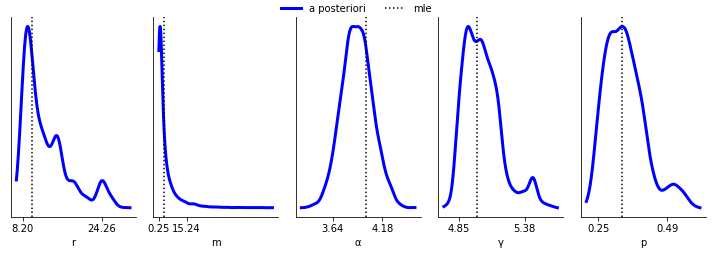

In [182]:
fig, axs = plt.subplots(1, len(parms_names), figsize=(10, 3.5))
x_labs = parms_names
for k in range(len(x_labs)):
    positions = np.linspace(min(trace_smc[parms_names[k]]), max(trace_smc[parms_names[k]]), 1000)
    kernel = st.gaussian_kde(trace_smc[parms_names[k]])
    axs[k].plot(positions, kernel(positions), lw=3, label = "a posteriori", color = "blue")

    axs[k].axvline(true_parms[k], color = "black", linestyle = "dotted", label = "mle")
    axs[k].set_yticks([])
    axs[k].set_xticks(np.round(
        trace_smc[parms_names[k]].quantile([0.05, 0.95]).values, 2))
    axs[k].set_xlabel(x_labs[k])

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol = 3, borderaxespad=0., loc='upper center', 
           frameon=False)
sns.despine()
fig.tight_layout()